# MLNS Final Project: Into the Networks of Life
------------------------------------------------------------
### Authors: Dwivedi Deepesh, Giacopelli Nicolò, Liu Dayu, Remadi Adel


# Graph Generation - VGAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.datasets import TUDataset
from layers import GCN, HGPSLPool
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
import numpy as np

In [ ]:
#load data and set label 1 data as our dataset(enz_dataset)
pro_dataset=TUDataset(root="/",name='PROTEINS')
enz_dataset = pro_dataset[[i for i in range(len(pro_dataset)) if pro_dataset[i].y == 1]]

In [ ]:
#check unique node feature values in dataset
x_set=[]
for i in range(len(enz_dataset)):
    for n in range(len(enz_dataset[i])):
        x_set.append(enz_dataset[i].x[n])
unique_x=[]
for x in x_set:
    if x.tolist() not in unique_x:
        unique_x.append(x.tolist())
unique_x

[[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]

# Pretrain

In [ ]:
class GCNEncoder_con(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder_con, self).__init__()
        self.fc1 = nn.Linear(in_channels, 32)
        self.fc2 = nn.Linear(32, 512)
        
        self.conv1 = GCNConv(512, 128) 
        self.lin1 = nn.Linear(512,128)
        
        self.conv2 = GCNConv(256, 128)
        self.lin2 = nn.Linear(256,128)
        
        self.conv3 = GCNConv(256, 256)
        self.lin3 = nn.Linear(256,256)
        
        self.linear1 = nn.Linear(256,out_channels)
 
    def forward(self, x, edge_index):
        x = self.fc1(x)
        x = F.dropout(x,p=0.3)
        x = self.fc2(x).relu()
        
        x_conv = self.conv1(x, edge_index)
        x_lin = self.lin1(x)
        x = torch.concatenate((x_conv,x_lin),axis=1).relu()
        x = F.dropout(x,training=self.training,p=0.2)
        
        x_conv = self.conv2(x, edge_index)
        x_lin = self.lin2(x)
        x = torch.concatenate((x_conv,x_lin),axis=1).relu()
        x = F.dropout(x,training=self.training,p=0.2)
        
        x_conv = self.conv3(x, edge_index)
        x_lin = self.lin3(x)
        x = x_conv*0.5+x_lin*0.5
        
        x = self.linear1(x)
        return x

In [ ]:
# parameters
out_channels = 64
num_features = 3
epochs = 1000
 
# model
model = GAE(GCNEncoder_con(num_features, out_channels))
 
# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# x = data.x.to(device)
# train_pos_edge_index = data.train_pos_edge_index.to(device)
# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002,weight_decay=1e-5)

In [ ]:
from torch_geometric.data import DataLoader
#train and test
enz_dataset.shuffle()
enz_train_dataloader=DataLoader(enz_dataset[:350], batch_size=25, shuffle=True)
enz_test_dataloader=DataLoader(enz_dataset[350:], batch_size=25)
def train():
    model.train()
    train_loss=0
    for data in enz_train_dataloader:
        data=data.to(device)
        optimizer.zero_grad()
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()
#         print(loss)
#         if loss.item()!= Nan:
        train_loss+=float(loss.item())
    return train_loss
 
def test():
    model.eval()
    test_loss=0
    for data in enz_test_dataloader:
        data=data.to(device)
        with torch.no_grad():
            z = model.encode(data.x, data.edge_index)
            loss = model.recon_loss(z, data.edge_index)
#             if loss.item()!= Nan:
            test_loss+=float(loss.item())
    return test_loss
#     return model.test(z, pos_edge_index, neg_edge_index)
best_test_loss=100
for epoch in range(1, epochs + 1):
    train_loss = train()
    test_loss = test()
    if epoch %20==0:
        print('Epoch: {:03d}, train loss: {:.4f}, test loss: {:.4f}'.format(epoch, train_loss, test_loss))
    if (test_loss<=best_test_loss):
        torch.save(model.state_dict(), f'best_epoch_GCN.pth' )
        best_test_loss=test_loss
print("best:",best_test_loss)

Epoch: 020, train loss: 15.7392, test loss: 4.7904
Epoch: 040, train loss: 14.8807, test loss: 4.5714
Epoch: 060, train loss: 14.5655, test loss: 4.3432
Epoch: 080, train loss: 14.2972, test loss: 4.4164
Epoch: 100, train loss: 13.8718, test loss: 4.2725
Epoch: 120, train loss: 13.3804, test loss: 4.2003
Epoch: 140, train loss: 13.1929, test loss: 4.1625
Epoch: 160, train loss: 12.9191, test loss: 4.0315
Epoch: 180, train loss: 12.6508, test loss: 3.9937
Epoch: 200, train loss: 12.5811, test loss: 3.9733
Epoch: 220, train loss: 12.5654, test loss: 3.8877
Epoch: 240, train loss: 12.3922, test loss: 3.9965
Epoch: 260, train loss: 12.3627, test loss: 4.0138
Epoch: 280, train loss: 12.3484, test loss: 4.0218
Epoch: 300, train loss: 12.1897, test loss: 3.9356
Epoch: 320, train loss: 12.2223, test loss: 3.9368
Epoch: 340, train loss: 12.1194, test loss: 3.9569
Epoch: 360, train loss: 12.0377, test loss: 3.8779
Epoch: 380, train loss: 12.1737, test loss: 3.9677
Epoch: 400, train loss: 11.9940

In [ ]:
#sample from real data
def sample_data(n_samples):
    enz_dataset.shuffle()
    return enz_dataset[:n_samples]

#get Z from our pre_trained best model, for single graph data
def get_z(data):
    model=GAE(GCNEncoder_con(3, 64)).to(device)
    model.load_state_dict(torch.load("best_epoch_GCN.pth", map_location='cpu'))
    z=model.encode(data.x.to(device), data.edge_index.to(device))
    return z.to(device)

#add noise and put z with noise into our DL model , output: Z_out
class simple_GAT_gen(torch.nn.Module):
    def __init__(self, hidden_dim):
        super(simple_GAT_gen, self).__init__()
        hidden_channels=hidden_dim
        self.conv1 = GATConv(3, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.lin_mean = nn.Linear(hidden_channels, 64)
        self.logvar = nn.Linear(hidden_channels, 64)
        
        self.regenerate_z=nn.Sequential()
        for i in range(5):
            self.regenerate_z.append(nn.Linear(64, 64))
            self.regenerate_z.append(nn.ReLU())
            self.regenerate_z.append(nn.Dropout(0.2))
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, data,z):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        mean=self.lin_mean(x)
        logvar=self.logvar(x)
        
        #adding noise
        z += self.reparameterize(mean, logvar)
        
        final_z=self.regenerate_z(z)
        
        return final_z

#using Z_out to calculate recon_loss
gen=simple_GAT_gen(hidden_dim=128).to(device)
optim_gen = torch.optim.Adam(gen.parameters(), lr=1e-5, betas=(0.5,0.9))
for i in range(200):
    loss_train=0
    enz_dataset.shuffle()
    train_dataloader=DataLoader(sample_data(200),batch_size=25,shuffle=True)
    for data in train_dataloader:
        data=data.to(device)
        final_z=gen(data.to(device),get_z(data).to(device))
        model=GAE(GCNEncoder_con(3, 64)).to(device)
        model.load_state_dict(torch.load("best_epoch_GCN.pth", map_location='cpu'))
        loss = model.recon_loss(final_z, data.edge_index)
        loss.backward()
        optim_gen.step()
        loss_train+=loss.item()
        
    if i%10==0:
        print("epoch:",i, " loss:", loss_train)

epoch: 0  loss: 11.159476280212402
epoch: 10  loss: 11.140681743621826
epoch: 20  loss: 11.128218531608582
epoch: 30  loss: 11.121505737304688
epoch: 40  loss: 11.112949252128601
epoch: 50  loss: 11.106317639350891
epoch: 60  loss: 11.103605508804321
epoch: 70  loss: 11.100906133651733
epoch: 80  loss: 11.097450971603394
epoch: 90  loss: 11.095338702201843
epoch: 100  loss: 11.094792008399963
epoch: 110  loss: 11.093193054199219
epoch: 120  loss: 11.09173583984375
epoch: 130  loss: 11.09105658531189
epoch: 140  loss: 11.091404676437378
epoch: 150  loss: 11.092083215713501
epoch: 160  loss: 11.09083878993988
epoch: 170  loss: 11.090651631355286
epoch: 180  loss: 11.090404629707336
epoch: 190  loss: 11.089493870735168


In [ ]:
test_dataloader=DataLoader(sample_data(450),batch_size=1, shuffle=True)
for data in test_dataloader:
    with torch.no_grad():
        data=data.to(device)
        final_z=gen(data.to(device),get_z(data).to(device))
        inner_product = torch.mm(final_z, final_z.t())
        break
# inner_product

tensor(0.0309, device='cuda:0')


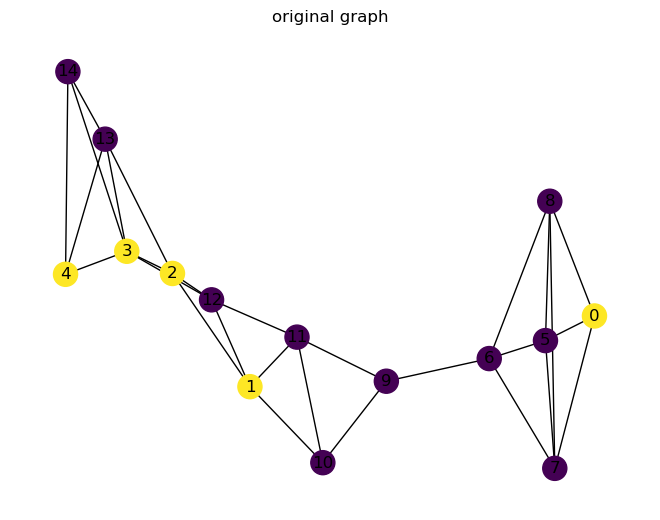

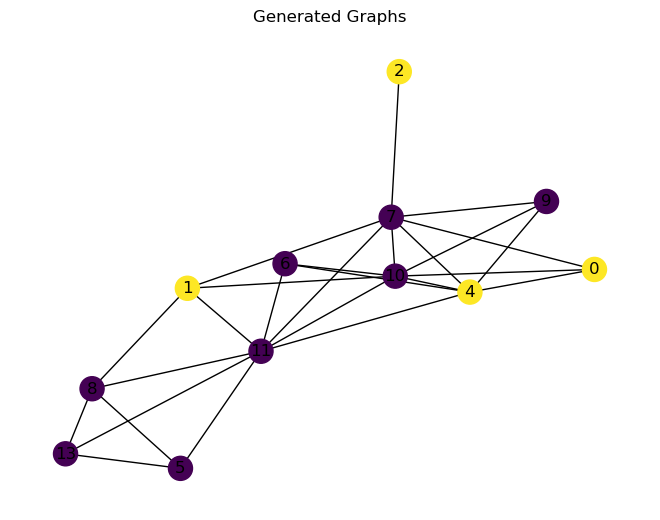

In [ ]:
for i in range(len(inner_product)):
    inner_product[i,i]=0
#let topn connected
top_values, top_indices = torch.topk(inner_product.flatten(), int(0.25*len(inner_product.nonzero())))
threshold=min(top_values)
print(threshold)
index = torch.where(inner_product < threshold, torch.zeros_like(inner_product), torch.ones_like(inner_product)).nonzero().T
n_feature=data.x
#visualization on real data
G = nx.Graph()
G.add_nodes_from(range(data.x.size(0)))
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, pos=nx.spring_layout(G), node_color=data.x.cpu()[:, 0], with_labels=True)
plt.title('original graph')
plt.show()
#visualization on generated data
G = nx.Graph()
G.add_nodes_from(range(n_feature.size(0)))
G.add_edges_from(index.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
n_feature = np.delete(n_feature.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=n_feature[:, 0], with_labels=True)
plt.title('Generated Graphs')
plt.show()

tensor(0.0296, device='cuda:0')


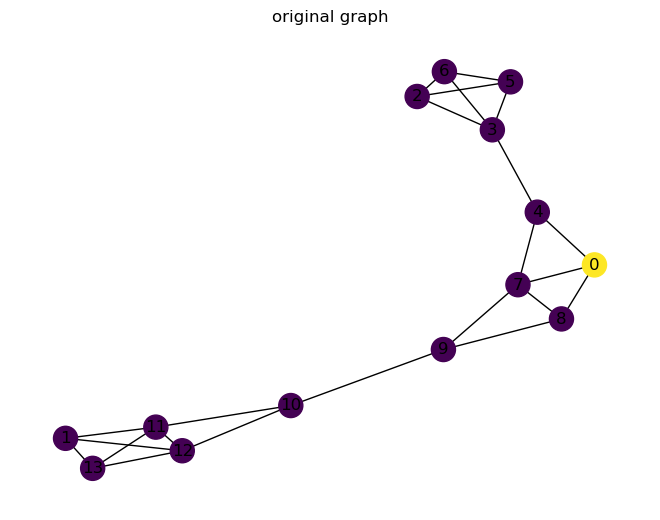

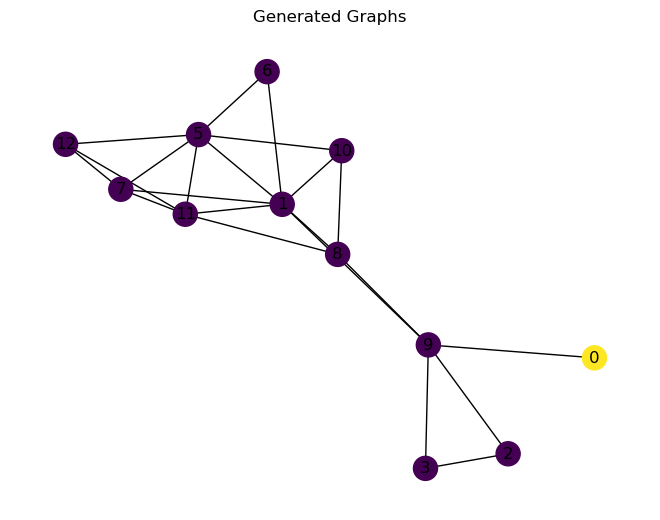

In [ ]:
for i in range(len(inner_product)):
    inner_product[i,i]=0

top_values, top_indices = torch.topk(inner_product.flatten(), int(0.25*len(inner_product.nonzero())))
threshold=min(top_values)
print(threshold)
index = torch.where(inner_product < threshold, torch.zeros_like(inner_product), torch.ones_like(inner_product)).nonzero().T
n_feature=data.x

G = nx.Graph()
G.add_nodes_from(range(data.x.size(0)))
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, pos=nx.spring_layout(G), node_color=data.x.cpu()[:, 0], with_labels=True)
plt.title('original graph')
plt.show()

G = nx.Graph()
G.add_nodes_from(range(n_feature.size(0)))
G.add_edges_from(index.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
n_feature = np.delete(n_feature.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=n_feature[:, 0], with_labels=True)
plt.title('Generated Graphs')
plt.show()

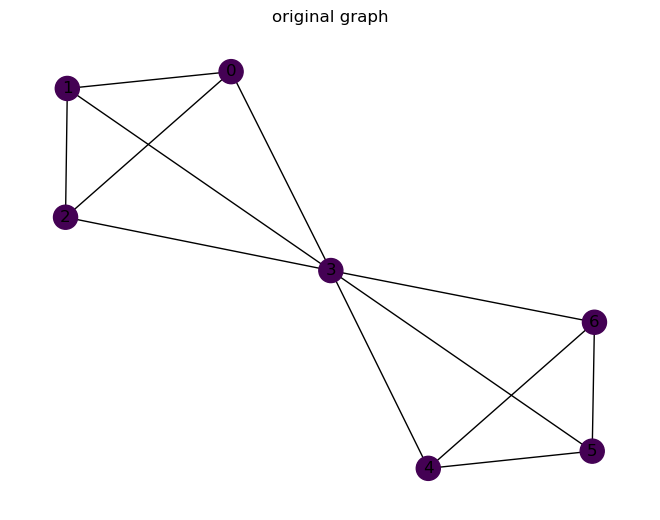

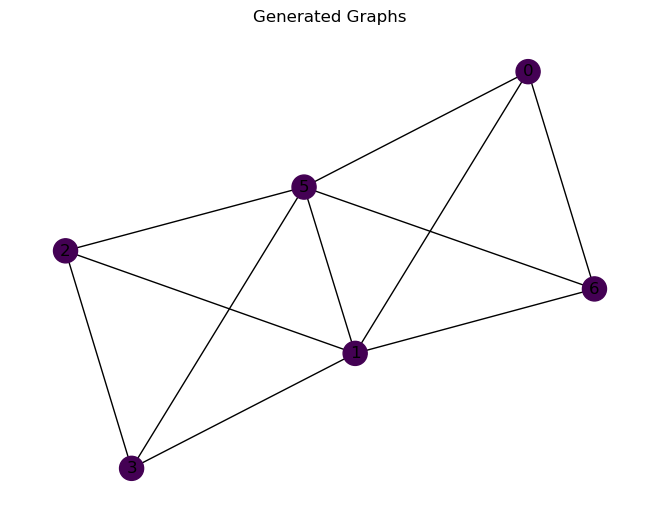

In [ ]:
for i in range(len(inner_product)):
    inner_product[i,i]=0

top_values, top_indices = torch.topk(inner_product.flatten(), int(0.25*len(inner_product.nonzero())))
threshold=min(top_values)
print(threshold)
index = torch.where(inner_product < threshold, torch.zeros_like(inner_product), torch.ones_like(inner_product)).nonzero().T
n_feature=data.x

G = nx.Graph()
G.add_nodes_from(range(data.x.size(0)))
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, pos=nx.spring_layout(G), node_color=data.x.cpu()[:, 0], with_labels=True)
plt.title('original graph')
plt.show()

G = nx.Graph()
G.add_nodes_from(range(n_feature.size(0)))
G.add_edges_from(index.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
n_feature = np.delete(n_feature.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=n_feature[:, 0], with_labels=True)
plt.title('Generated Graphs')
plt.show()

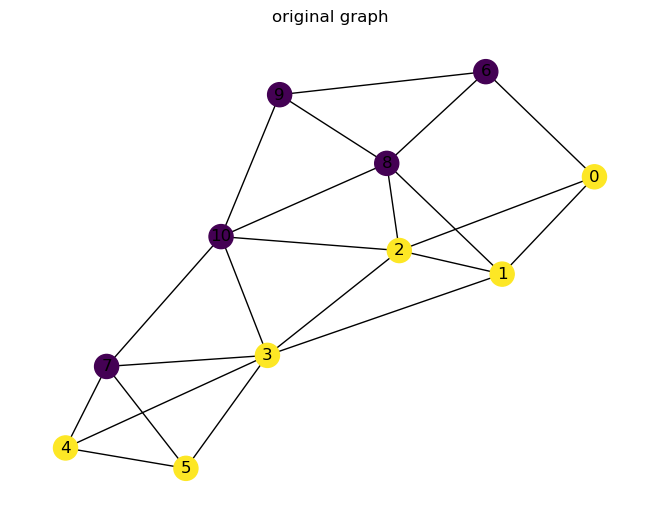

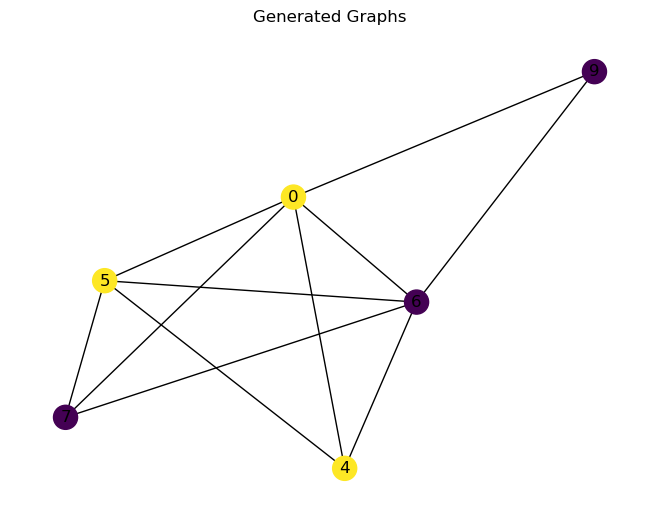

In [ ]:
for i in range(len(inner_product)):
    inner_product[i,i]=0

top_values, top_indices = torch.topk(inner_product.flatten(), int(0.25*len(inner_product.nonzero())))
threshold=min(top_values)
print(threshold)
index = torch.where(inner_product < threshold, torch.zeros_like(inner_product), torch.ones_like(inner_product)).nonzero().T
n_feature=data.x

G = nx.Graph()
G.add_nodes_from(range(data.x.size(0)))
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, pos=nx.spring_layout(G), node_color=data.x.cpu()[:, 0], with_labels=True)
plt.title('original graph')
plt.show()

G = nx.Graph()
G.add_nodes_from(range(n_feature.size(0)))
G.add_edges_from(index.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
n_feature = np.delete(n_feature.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=n_feature[:, 0], with_labels=True)
plt.title('Generated Graphs')
plt.show()

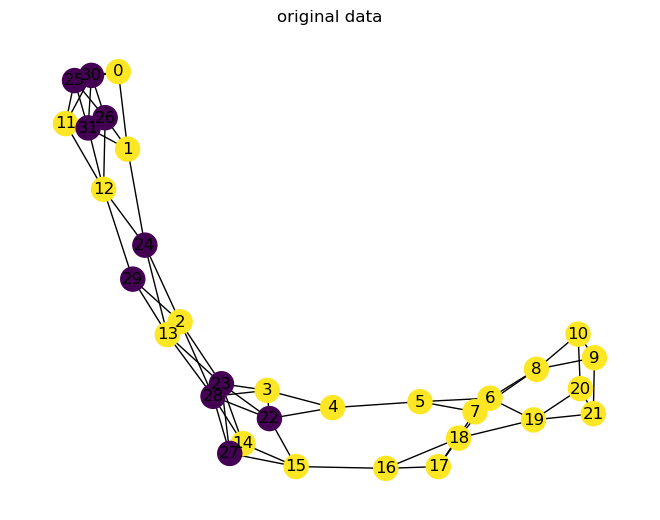

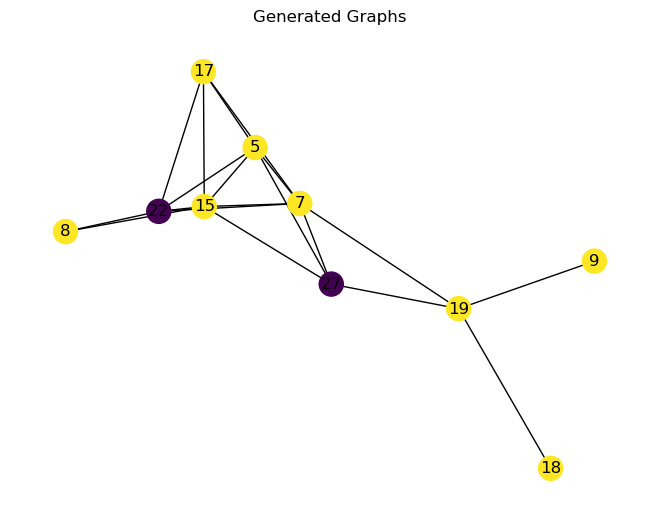

In [ ]:
for i in range(len(inner_product)):
    inner_product[i,i]=0

top_values, top_indices = torch.topk(inner_product.flatten(), int(0.25*len(inner_product.nonzero())))
threshold=min(top_values)
print(threshold)
index = torch.where(inner_product < threshold, torch.zeros_like(inner_product), torch.ones_like(inner_product)).nonzero().T
n_feature=data.x

G = nx.Graph()
G.add_nodes_from(range(data.x.size(0)))
G.add_edges_from(data.edge_index.t().tolist())
nx.draw(G, pos=nx.spring_layout(G), node_color=data.x.cpu()[:, 0], with_labels=True)
plt.title('original graph')
plt.show()

G = nx.Graph()
G.add_nodes_from(range(n_feature.size(0)))
G.add_edges_from(index.t().tolist())
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)
n_feature = np.delete(n_feature.cpu().numpy(), isolates, axis=0)
nx.draw(G, pos=nx.spring_layout(G), node_color=n_feature[:, 0], with_labels=True)
plt.title('Generated Graphs')
plt.show()

# Evaluate with SOTA model - Generator performance

In [ ]:
from sklearn.model_selection import train_test_split
model = ClassifierModel(args).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.NLLLoss()
best_performance = torch.load('model_hgpsl_pool.pt')
model.load_state_dict(best_performance)

<All keys matched successfully>

In [ ]:
test_dataloader=DataLoader(sample_data(300),batch_size=1, shuffle=True)
generated_list=[]
for data in test_dataloader:
    with torch.no_grad():
        data=data.to(device)
        final_z=gen(data.to(device),get_z(data).to(device))
        inner_product = torch.mm(final_z, final_z.t())
        for i in range(len(inner_product)):
            inner_product[i,i]=0
        top_values, top_indices = torch.topk(inner_product.flatten(), int(0.2*len(inner_product.nonzero())))
        threshold=min(top_values)
        index = torch.where(inner_product < threshold, torch.zeros_like(inner_product), torch.ones_like(inner_product)).nonzero().T
    generated_list.append(Data(x=data.x,edge_index=index))   

In [ ]:
#SOTA model evaluate on generated graphs
model.eval()
ones = 0
for data in generated_list:
    data = data.to(device)
    with torch.no_grad():
        out = model(data)
    pred = out.argmax(dim=1)
    ones += (pred).sum().item()
print(f"Percentage of generated graphs recognized as enzymes by SOTA classifier on protein dataset: {ones/3}%")

Percentage of generated graphs recognized as enzymes by SOTA classifier on protein dataset: 42.0%
